In [1]:
import os
from os.path import join, exists, basename, dirname, expanduser
from glob import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import rioxarray as rxa
from scipy import stats
from pyproj import Transformer

with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)

image_fps = [f for f in image_fps if f['fp'].endswith('.unw.grd.tiff')]
netcdf_fps = '/bsuhome/zacharykeskinen/scratch/data/uavsar/images/vv_coherence'

data_fp = '/bsuhome/zacharykeskinen/scratch/data/uavsar/coherence'
with open(join(data_fp,'cor_vv.pkl'), 'rb') as f:
    cor_vv = pickle.load(f)

In [2]:
def clean_nps(arrs):
    idx = np.zeros_like(arrs[0], dtype = arrs[0].dtype)
    for arr in arrs:
        idx += arr

    for i in range(len(arrs)):
        arrs[i] = arrs[i][np.where(~np.isnan(idx))]
    return arrs

def clean_two_nps(arr1, arr2):
    buff = arr1
    arr1 = arr1[(~np.isnan(arr1)) & (~np.isnan(arr2))]
    arr2 = arr2[(~np.isnan(buff)) & (~np.isnan(arr2))]
    return arr1, arr2

def datarray_to_numpy(x, y):
    if type(x)== xr.core.dataarray.DataArray:
        x_dirty = x.values.ravel()
        y = y.values.ravel()
    else:
        x_dirty = x
    x = x_dirty[(~np.isnan(x_dirty)) & (~np.isnan(y))]
    y = y[(~np.isnan(x_dirty)) & (~np.isnan(y))]
    return x, y

def r2_value(x, y):
    x, y = datarray_to_numpy(x,y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print(f'slope: {slope}. intercept: {intercept}. r_value {r_value}. p value: {p_value}')
    return slope, intercept, r_value, p_value, x, y

def mann_test(x, y, xlabel = 'x', ylabel = 'y'):
    x, y = datarray_to_numpy(x,y)
    stat, p = mannwhitneyu(x, y)   
    print(f'Comparison of {xlabel} vs {ylabel} center has a p value of {p:.10f} of not being from same distribution with {len(x)} observations.')
    if p < 0.1:
        print(f'Median of {xlabel}: {np.median(x)} compared to median of {ylabel}: {np.median(y)}')

In [3]:
lidar_dir = '/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar'
for d in glob(join(lidar_dir,'*')):
    if 'taylor' in d:
        pass
    elif 'Lowman' in d:
        for sf in glob(join(d, '*')):
            for f in glob(join(sf, '*.tif')):
                subloc = basename(sf)
                date = basename(f).split('_')[-2]
                if '_SD_' in f or 'snowdepth' in f:
                    sd = rxa.open_rasterio(f)
                    sd_re = sd.rio.reproject_match(cor_vv['Lowman,_CO'])[0]
                    cor_vv['Lowman,_CO'][f'{subloc}-{date}-sd'] = sd_re.where(sd_re < 1000)
                elif '_VH_' in f:
                    veg = rxa.open_rasterio(f)
                    veg_re = veg.rio.reproject_match(cor_vv['Lowman,_CO'])[0]
                    cor_vv['Lowman,_CO'][f'{subloc}-{date}-veg'] = veg_re.where(veg_re < 1000)
    else:
        for f in glob(join(d, '*.tif')):
            date = basename(f).split('_')[-2]
            if 'EastRiver' in f:
                date = '20200214'
            if '_SD_' in f or 'snowdepth' in f:
                sd = rxa.open_rasterio(f)
                sd_re = sd.rio.reproject_match(cor_vv[dirname(f)])[0]
                cor_vv[dirname(f)][f'{date}-sd'] = sd_re.where(sd_re < 1000)
            elif '_VH_' in f:
                veg = rxa.open_rasterio(f)
                veg_re = veg.rio.reproject_match(cor_vv[dirname(f)])[0]
                cor_vv[dirname(f)][f'{date}-veg'] = veg_re.where(veg_re < 1000)

In [77]:
f

'/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/banner/SNEX20_QSI_VH_0.5M_USIDBS_20210315_20210315.tif'

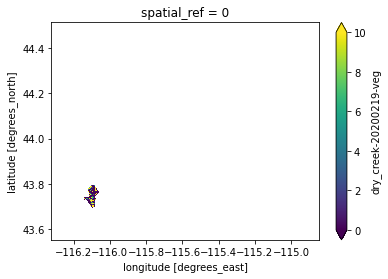

In [75]:
cor_vv['Lowman,_CO']['dry_creek-20200219-veg'].plot(vmin = 0, vmax = 10)